In [ ]:
#default_exp redmine

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#export
import getpass
import re
import logging
from pathlib import Path
from typing import Iterable, Union
from collections import defaultdict
from redminelib import Redmine
import pandas as pd
from fastcore.test import *
from fastcore.basics import partialler, listify
from anateldb.constants import *

# Redmine

> Scripts para baixar informações sobre inspeções no Fiscaliza e atualizá-las.

In [ ]:
#hide
USR = getpass.getuser()
PWD = getpass.getpass()
PROJ = 'gr01'
INSP = '36964'
logging.basicConfig(filename='fiscaliza.log', level=logging.INFO)

## Exemplo de Definições
```python
d['Classe da Inspeção'] = 'Técnica' #string

d['Tipo de inspeção'] = 'Uso do Espectro - Monitoração' #string

d['Descrição da Inspeção'] = '''Atendimento da Denúncia AC202010213075425 (6104512), 
verificação da Potência e Intensidade de Campo Elétrico da Frequência 105.1MHz e seus harmônicos, 
além da checagem de Intermodulação e Espúrios nas frequências 450.3MHz e 750MHz.''' #string de 1 ou várias linhas

d['Fiscal responsável '] = 'Ronaldo da Silva Alves Batista' #string

d['Fiscais '] = 'Ronaldo da Silva Alves Batista' | ['Ronaldo da Silva Alves Batista', 'Paulo Diogo Costa', 'Mario Augusto Volpini'] #string ou lista de strings

# A string sem o 'r' ( raw ) antes tende a ser interpretada incorretamente pelo Windows
d['Html'] = r'D:\Processos\Report_2021.02.18_T23.49.55.html' | '/d/Processos/Report_2021.02.18_T23.49.55.html' # Esse formato é preferível porque não precisa ser antecedido de 'r' # string nesses formatos

d[' Gerar Relatório '] = 1 # int 0 ou 1

d['Frequência inicial']  = 54 #int ou float

d['Unidade da frequência inicial'] = 'MHz' #string

d['Frequência final'] = 700 #int ou float

d['Unidade da frequência final'] = 'MHz' #string

d['Data de início'] = '2021-03-19' #YYYY-MM-DD #string nesse formato

d['Data limite'] = '2021-12-31'  #YYYY-MM-DD #string nesse formato

d['UF/Município'] = "SP/São Paulo" | ["SP/São Paulo", "SP/Sorocaba"] # String ou Lista de Strings

d['Serviços da Inspeção'] = '230' | ['230', '231', '800'] # String ou Lista de Strings

d['Qnt. de emissões na faixa'] = 12 # int

d['Emissões não autorizadas/desc'] = 70 # int

d['Horas de Preparação'] = 2 # int

d['Horas de Deslocamento'] = 0 # int

d['Horas de Execução'] = 32 # int

d['Horas de conclusão'] = 6 # int

d['Latitude (coordenadas)'] = -22.94694 # float

d['Longitude (coordenadas)'] = -43.21944 # float

d['Uso de PF'] = 'Não se aplica PF - uso apenas de formulários' # string

d['Ação de risco à vida criada?'] = 'Não' # string Sim | Não

d['Impossibilidade acesso online?'] = '0' # string '0' | '1'

d['notes'] = "Não foi constatada irregularidade no Período monitorado" # string

# No caso de uma tabela 

d['notes'] = """Faixa, Classe Especial, \Classe A, Classe B, Classe C
                VHF-L,0,5,7,5
                VHF-H,0,12,1,0
                UHF,1,1,2,4
                FM,5,1,0,0
                RADCOM,0,0,0,0
                Outorgadas com indícios de irregularidades,1,2,3,4 #string multilinhas com a primeira coluna como título e as demais como valores, O número de valores deve ser igual ao número de colunas para todas as linhas.
            """
```

## Funções Auxiliares e Informações de Inspeção / Ação

In [ ]:
#export
def value_text_string(input_value):
    return '{' + '"valor":"{0}","texto":"{0}"'.format(input_value) + '}'

def auth_user(username, password, teste=True, verify=True):
    url = URLHM if teste else URL
    fiscaliza = Redmine(url, username=username, password=password, requests={'verify': verify})
    fiscaliza.auth()
    return fiscaliza

def valida_fiscaliza(fiscaliza_obj: Redmine)->None:
    if not isinstance(fiscaliza_obj, Redmine):
        raise TypeError(f"O Objeto Fiscaliza deve ser uma instância autenticada "\
        "(logada) da classe Redmine, o typo do objeto fornecido é {type(fiscaliza_obj)}")

def issue2users(fiscaliza: Redmine, issue: str)-> dict:
    """Recebe objeto Redmine e string issue com o número da issue e retorna um dicionário com os usuários do grupo Inspeção-Execução"""
    valida_fiscaliza(fiscaliza)
    proj = fiscaliza.issue.get(issue).project.name.lower()
    members = fiscaliza.project_membership.filter(project_id=proj)
    id2name = {}
    name2id = {}
    names = []
    for member in members:
        if roles := getattr(member, 'roles', []):
            for role in roles:
                if str(role) == 'Inspeção-Execução':
                    if user := getattr(member, 'user', None):
                        if (id_ := getattr(user, 'id', None)) and (name := getattr(user, 'name', None)):
                            names.append((id_, name))
                            
    names.sort(key=lambda x: x[1])
    id2name = dict(names)
    name2id = {v:k for k,v in id2name.items()}
    return id2name, name2id

def insp2acao(insp: str, fiscaliza: Redmine)->dict:        
    """Recebe o objeto `fiscaliza` e a string referente à inspeção `insp` e retorna um dicionário resumo da Ação atrelada à inspeção

    Args:
        redmineObj (Redmine): Objeto Redmine autenticado
        insp (str): string com o número da inspeção

    Returns:
        dict: Dicionário com o id, nome e descrição da Ação associada à inspeção
    >>>fiscaliza = Redmine(URL, username=USR, password=PWD)
       fiscaliza.auth()
       detalhar_inspecao(fiscaliza, '51804')
    {'id': 51803,
    'name': 'ACAO_GR01_2021_0456',
    'description': 'Atendimento à Denúncia AC202010213075425 (6104512)'}
    """
    valida_fiscaliza(fiscaliza)
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    if relations := getattr(issue, 'relations', []):
        if relations := getattr(relations, 'values', []):
            relations = relations()
    for relation in relations:
        if (issue_to_id := relation.get('issue_to_id', None)):
            if (issue_to_id := fiscaliza.issue.get(issue_to_id)):
                if 'ACAO' in str(issue_to_id) or ((tracker := getattr(issue_to_id, 'tracker', None)) and (getattr(tracker, 'id', None) == 2)):
                    if (description := getattr(issue_to_id, 'custom_fields', None)) is not None:
                        if description := description.get(ACAO_DESCRIPTION, None):
                            description = getattr(description, 'value', '')
                        else:
                            description = ''
                    else:
                        description = ''
                    return {'id': getattr(issue_to_id, 'id', ''), 'name': str(issue_to_id), 'description': description}
    else:
        return {'id': '', 'name': '', 'description': ''}


def detalhar_inspecao(insp: str, fiscaliza: Redmine=None)->dict:
    valida_fiscaliza(fiscaliza)
    result = {k:'' for k in FIELDS}
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    result.update({k: str(getattr(issue,k, '')) for k in FIELDS})
    if custom_fields := getattr(issue, 'custom_fields', None):
        custom_fields = list(custom_fields)
        for field in custom_fields:
            key = field.id
            if key in CUSTOM_IDS:
                value = getattr(field, 'value', '')
                result[ID2FIELD[key]] = value
    return result

def rascunho2aguardando(insp, fields, fiscaliza):
    valida_fiscaliza(fiscaliza)    
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    status = str(getattr(issue, 'status', ''))
    if status != 'Rascunho':
        logging.info(f"Editando 'Rascunho' mas o status atual da Inspeção {status} é diferente de 'Rascunho'")
    status = list(STATUS.keys())[0]
    custom_fields = []
    for field in STATUS[status]:
        if not (updated_val := fields.get(field, None)):
                continue
        if field not in ('Fiscal responsável ', 'Fiscais '):
            if field in ('Classe da Inspeção', 'Tipo de inspeção'):
                #updated_val = fields.get(field)
                updated_val = value_text_string(updated_val)
            custom_fields.append({'id': FIELD2ID[field], 'value': updated_val})
    issue_id = issue.id
    _, name2id = issue2users(fiscaliza, issue_id)
    if responsavel := fields.get('Fiscal responsável ', None):
        custom_fields.append({'id': FIELD2ID['Fiscal responsável '], 'value': name2id[responsavel]})
    if fiscais := fields.get('Fiscais ', None):
        if type(fiscais) not in (tuple, list):
            fiscais = [fiscais]
        custom_fields.append({'id': FIELD2ID['Fiscais '], 'value': [name2id[f] for f in fiscais]})
    status = SITUACAO[status]
    return fiscaliza.issue.update(issue_id, status_id=status, custom_fields=custom_fields)

## Validação de Informações e Atualização de Inspeção 

In [ ]:
#export 
def check_update(field: str, value , dtype, values_set: Iterable=None, val_text_string: bool = False):    
    if not isinstance(value, dtype):
        raise TypeError(f"É esperado que o campo {value} seja do tipo {str}, o fornecido foi {type(value)}")
    
    if values_set is not None and not set(listify(value)).issubset(set(values_set)):
        raise ValueError(f"O valor para {field} : {value} deve pertencer ao conjunto: {values_set}")
        
    if val_text_string:
        value = value_text_string(value)
        
    return {'id': FIELD2ID[field], 'value': value}
        
def validate_datadict(data_dict: dict, insp: str, fiscaliza: Redmine)->dict:
    
    assert isinstance(data_dict, dict), f"É esperado um dicionário como entrada, {data_dict} é do tipo: {type(data_dict)}" 
    
    if not set(data_dict.keys()).issubset(DICT_FIELDS):
        raise ValueError(f'As chaves seguintes são desconhecidas ou estão com o nome diferente do esperado: \
                         {set(data_dict.keys()).difference(DICT_FIELDS)}')
        
    assert isinstance(fiscaliza, Redmine), f"Uma instância do tipo Redmine é esperada, foi retornado objeto fiscaliza {type(fiscaliza)}"
        
    valida_fiscaliza(fiscaliza)    
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    issue_id = issue.id
    
    date_pattern = '([2]\d{3})-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01])'
    
    d = data_dict.copy()

    key = DICT_FIELDS[0]
    if (classe := d.get(key)):
        d[key] = check_update(key, classe, str, CLASSE, True)
        
    key = DICT_FIELDS[1]
    if (tipo := d.get(key)):
        d[key] = check_update(key, tipo, str, TIPO, True)
        
    key = DICT_FIELDS[2]
    if (description := d.get(key)):
        d[key] = check_update(key, description, str)
    
    key = DICT_FIELDS[3]
    if (fiscal := d.get(key)):
        _, name2id = issue2users(fiscaliza, issue_id)
        d[key] = check_update(key, fiscal, str, name2id.keys())
        
    key = DICT_FIELDS[4]
    if (fiscais := d.get(key)):
        _, name2id = issue2users(fiscaliza, issue_id)
        fiscais = listify(fiscais)
        d[key] = check_update(key, fiscais, list, name2id.keys())
        
    key = DICT_FIELDS[5]
    if (html := d.get(key)):
        html = Path(html)
        assert html.exists() and html.is_file(), f"O caminho para o arquivo html informado não existe ou não é um arquivo: {html}"
        d[key] = check_update(key, html.read_text(), str)
        key = DICT_FIELDS[6]
        if (relatorio := d.get(key, None)):
            d[key] = check_update(key, relatorio, int, (0,1))
    
    key = DICT_FIELDS[7]
    if (freq_init := d.get(key)):
        d[key] = check_update(key, freq_init, (int,float))
    
    key = DICT_FIELDS[8]
    if (init_unit := d.get(key)):
        d[key] = check_update(key, init_unit, str, ('kHz', 'MHz', 'GHz'))
    
    key = DICT_FIELDS[9]
    if (freq_final := d.get(key)):
        d[key] = check_update(key, freq_final, (int,float))
    
    key = DICT_FIELDS[10]
    if (final_unit := d.get(key)):
        d[key] = check_update(key, final_unit, str, ('kHz', 'MHz', 'GHz'))
        
    key = DICT_FIELDS[11]
    if (start_date := d.get(key)):
        assert re.match(date_pattern, start_date), f'A data informada é inválida {start_date}, informe o formato yyyy-mm-dd'
        d[key] = start_date
    else:
        raise ValueError(f'O campo "Data de início" não pode ficar vazio!')
    
    key = DICT_FIELDS[12]
    if (due_date := d.get(key)):
        assert re.match(date_pattern, due_date), f'A data informada é inválida {due_date}, informe o formato yyyy-mm-dd'
        d[key] = due_date
    else:
        raise ValueError(f'O campo "Data limite" não poder ficar vazio!')        
    
    key = DICT_FIELDS[13]
    if (municipio := d.get(key)):
        municipios = pd.read_pickle('municipios.pkl')
        municipio = listify(municipio)
        lista_municipios = []
        for m in municipio:
            match =  re.match(f'({"|".join(ESTADOS)})/(\w+[\s|\w]+)', m)
            if not match:
                raise ValueError(f'Verifique o formato da string UF/Município: {m}')
                    
            lista_municipios.append(check_update(key, m, str, municipios))
        
        d[key] = lista_municipios
        del municipios
    
            
    return d

In [ ]:
#hide
fiscaliza = auth_user(USR, PWD)
insp2acao(INSP, fiscaliza)

{'id': 23210,
 'name': 'ACAO_GR01_2020_0035',
 'description': 'PRD-Aspectos Técnicos\r\nCentralização de denúncias de Radiodifusão com motivo Aspectos Técnicos pela GR01FI3 (Laert)'}

In [ ]:
detalhar_inspecao(51804, fiscaliza)

{'id': '51804',
 'subject': 'INSP_GR01_2021_0449',
 'status': 'Conferida',
 'priority': 'Normal',
 'start_date': '2020-10-22',
 'due_date': '2021-03-31',
 'Classe da Inspeção': '{"valor":"Técnica","texto":"Técnica"}',
 'Tipo de inspeção': '{"valor":"Uso do Espectro - Monitoração","texto":"Uso do Espectro - Monitoração"}',
 'Descrição da Inspeção': 'Atendimento da Denúncia AC202010213075425 (6104512), verificação da Potência e Intensidade de Campo Elétrico da Frequência 105.1MHz e seus harmônicos, além da checagem de Intermodulação e Espúrios nas frequências 450.3MHz e 750MHz.',
 'Fiscal responsável ': '887',
 'Fiscais ': ['887'],
 'UF/Município': ['{"valor":"RJ/Rio de Janeiro","texto":"RJ/Rio de Janeiro"}'],
 'Serviços da Inspeção': ['{"valor":"230 - COLETIVO - RADIODIFUSÃO SONORA EM FREQÜÊNCIA MODULADA","texto":"230 - COLETIVO - RADIODIFUSÃO SONORA EM FREQÜÊNCIA MODULADA"}'],
 'Qnt. de emissões na faixa': '1',
 'Emissões não autorizadas/desc': '0',
 'Horas de Preparação': '2',
 'Horas

In [ ]:
d = {}

d['Classe da Inspeção'] = 'Técnica'

d['Tipo de inspeção'] = 'Uso do Espectro - Monitoração'

d['Descrição da Inspeção'] = '''Atendimento da Denúncia AC202010213075425 (6104512), 
verificação da Potência e Intensidade de Campo Elétrico da Frequência 105.1MHz e seus harmônicos, 
além da checagem de Intermodulação e Espúrios nas frequências 450.3MHz e 750MHz.'''

d['Fiscal responsável '] = 'Ronaldo da Silva Alves Batista'

d['Fiscais '] = ['Ronaldo da Silva Alves Batista', 'Paulo Diogo Costa', 'Mario Augusto Volpini'] #string ou lista de strings

# A string sem o 'r' ( raw ) antes tende a ser interpretada incorretamente pelo Windows
d['Html'] = 'D:\\OneDrive - ANATEL\\Monitoramento\\Processos\\53504.0005432021-55\\Guarulhos.html'
           #r'D:\OneDrive - ANATEL\Monitoramento\Processos\53504.0005432021-55\Guarulhos.html'
           #'/d/OneDrive - ANATEL/Monitoramento/53504.0005432021-55/Guarulhos.html' 
            
d[' Gerar Relatório '] = 1 # int 0 ou 1

d['Frequência inicial']  = 54 #int ou float

d['Unidade da frequência inicial'] = 'MHz' #string

d['Frequência final'] = 700 #int ou float

d['Unidade da frequência final'] = 'MHz' #string

d['Data de início'] = '2021-03-19' #YYYY-MM-DD #string nesse formato

d['Data limite'] = '2021-12-31'  #YYYY-MM-DD #string nesse formato

d['UF/Município'] = "SP/São Paulo" #| ["SP/São Paulo", "SP/Sorocaba"] # String ou Lista de Strings

d['Serviços da Inspeção'] = '230' #| ['230', '231', '800'] # String ou Lista de Strings

d['Qnt. de emissões na faixa'] = 12 # int

d['Emissões não autorizadas/desc'] = 70 # int

d['Horas de Preparação'] = 2 # int

d['Horas de Deslocamento'] = 0 # int

d['Horas de Execução'] = 32 # int

d['Horas de conclusão'] = 6 # int

d['Latitude (coordenadas)'] = -22.94694 # float

d['Longitude (coordenadas)'] = -43.21944 # float

d['Uso de PF'] = 'Não se aplica PF - uso apenas de formulários' # string

d['Ação de risco à vida criada?'] = 'Não' # string Sim | Não

d['Impossibilidade acesso online?'] = '0' # string '0' | '1'

d['notes'] = "Não foi constatada irregularidade no Período monitorado" # string

# No caso de uma tabela 

d['notes'] = """Faixa, Classe Especial, Classe A, Classe B, Classe C
                VHF-L,0,5,7,5
                VHF-H,0,12,1,0
                UHF,1,1,2,4
                FM,5,1,0,0
                RADCOM,0,0,0,0
                Outorgadas com indícios de irregularidades,1,2,3,4 #string multilinhas com a primeira coluna como título e as demais como valores, O número de valores deve ser igual ao número de colunas para todas as linhas.
            """


{'Classe da Inspeção': {'id': 89,
  'value': '{"valor":"Técnica","texto":"Técnica"}'},
 'Tipo de inspeção': {'id': 2,
  'value': '{"valor":"Uso do Espectro - Monitoração","texto":"Uso do Espectro - Monitoração"}'},
 'Descrição da Inspeção': {'id': 22,
  'value': 'Atendimento da Denúncia AC202010213075425 (6104512), \nverificação da Potência e Intensidade de Campo Elétrico da Frequência 105.1MHz e seus harmônicos, \nalém da checagem de Intermodulação e Espúrios nas frequências 450.3MHz e 750MHz.'},
 'Fiscal responsável ': {'id': 25, 'value': 'Ronaldo da Silva Alves Batista'},
 'Fiscais ': {'id': 26,
  'value': ['Ronaldo da Silva Alves Batista',
   'Paulo Diogo Costa',
   'Mario Augusto Volpini']},
 'Html': {'id': 585,
  'value': '<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01//EN" "http://www.w3.org/TR/html4/strict.dtd">\n<html lang="pt-br">\n\n<head>\n\t<meta http-equiv="Pragma" content="no-cache">\n\t<meta http-equiv="Content-Type" content="text/html; charset=windows-1252">\n\t<style ty
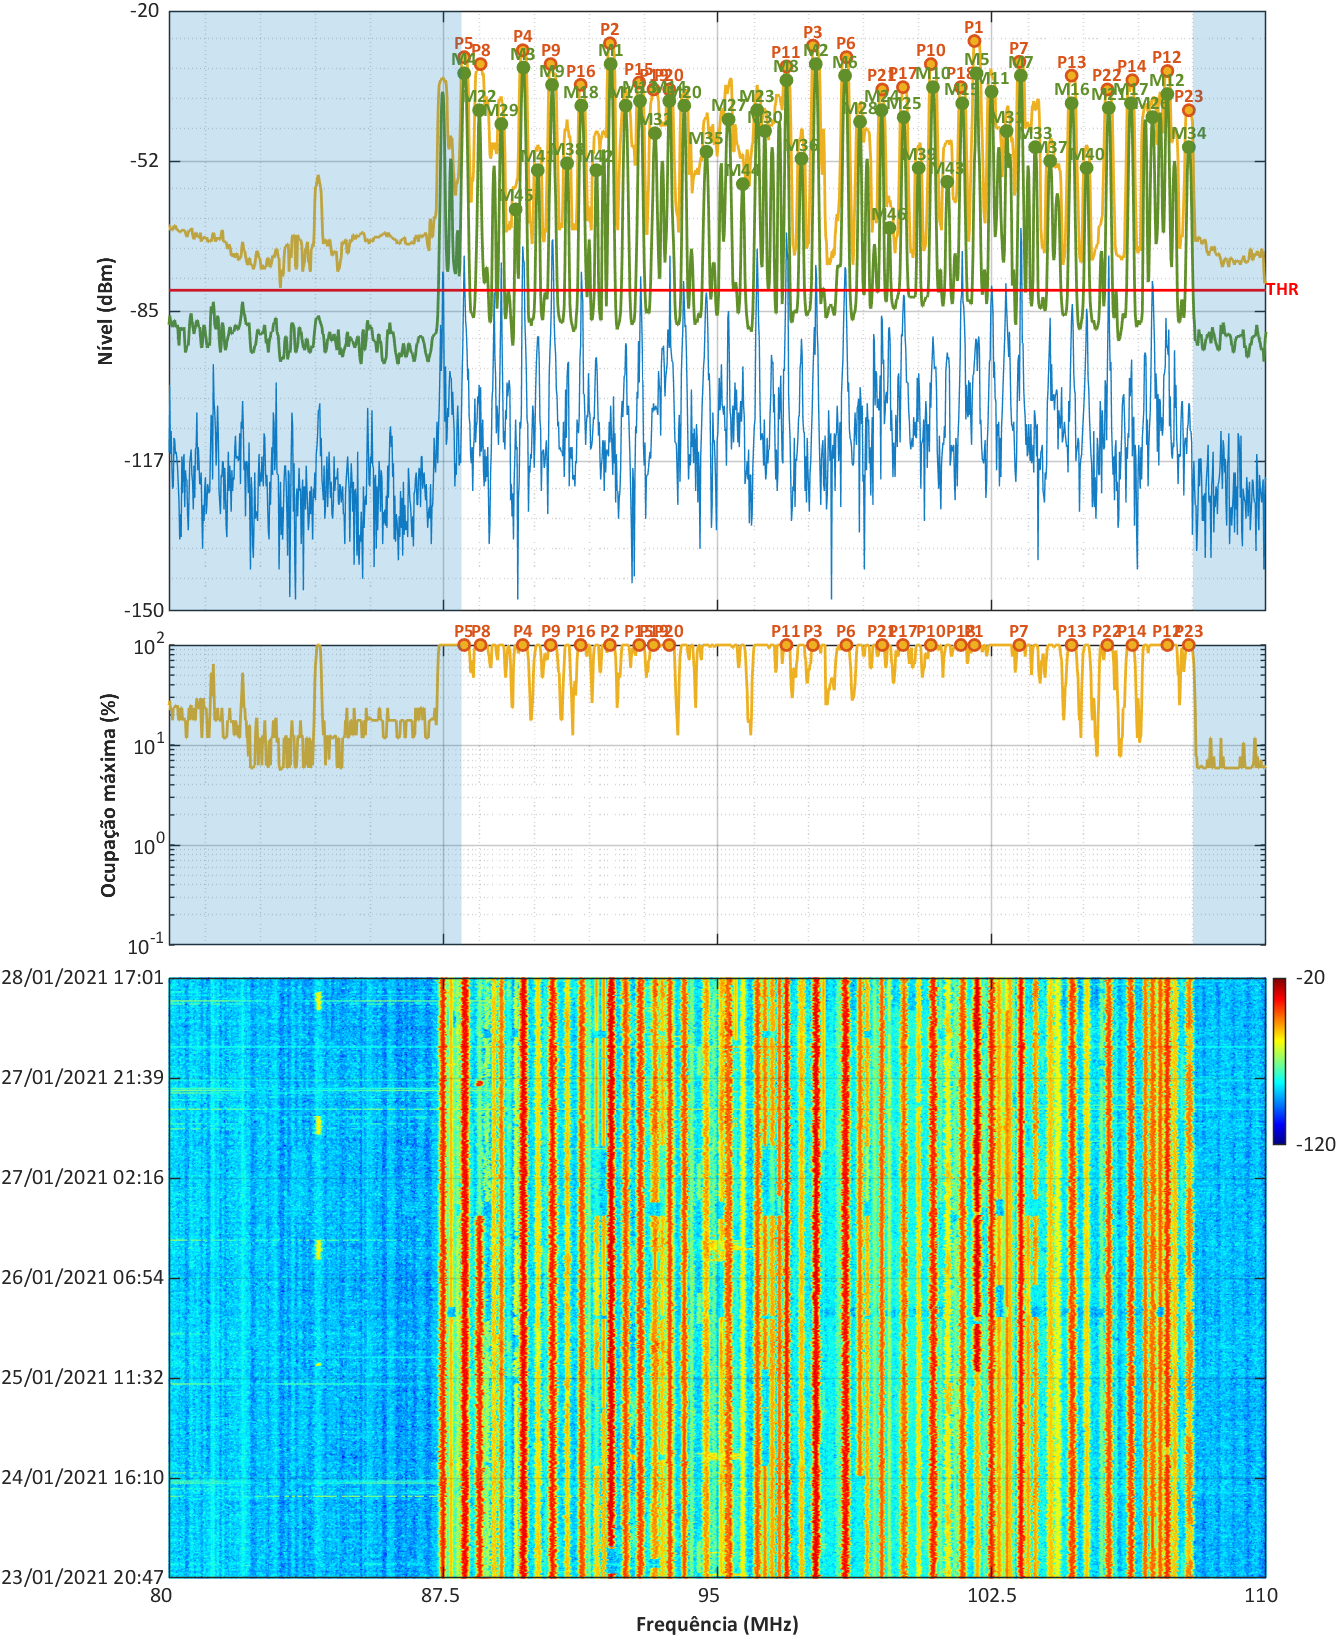
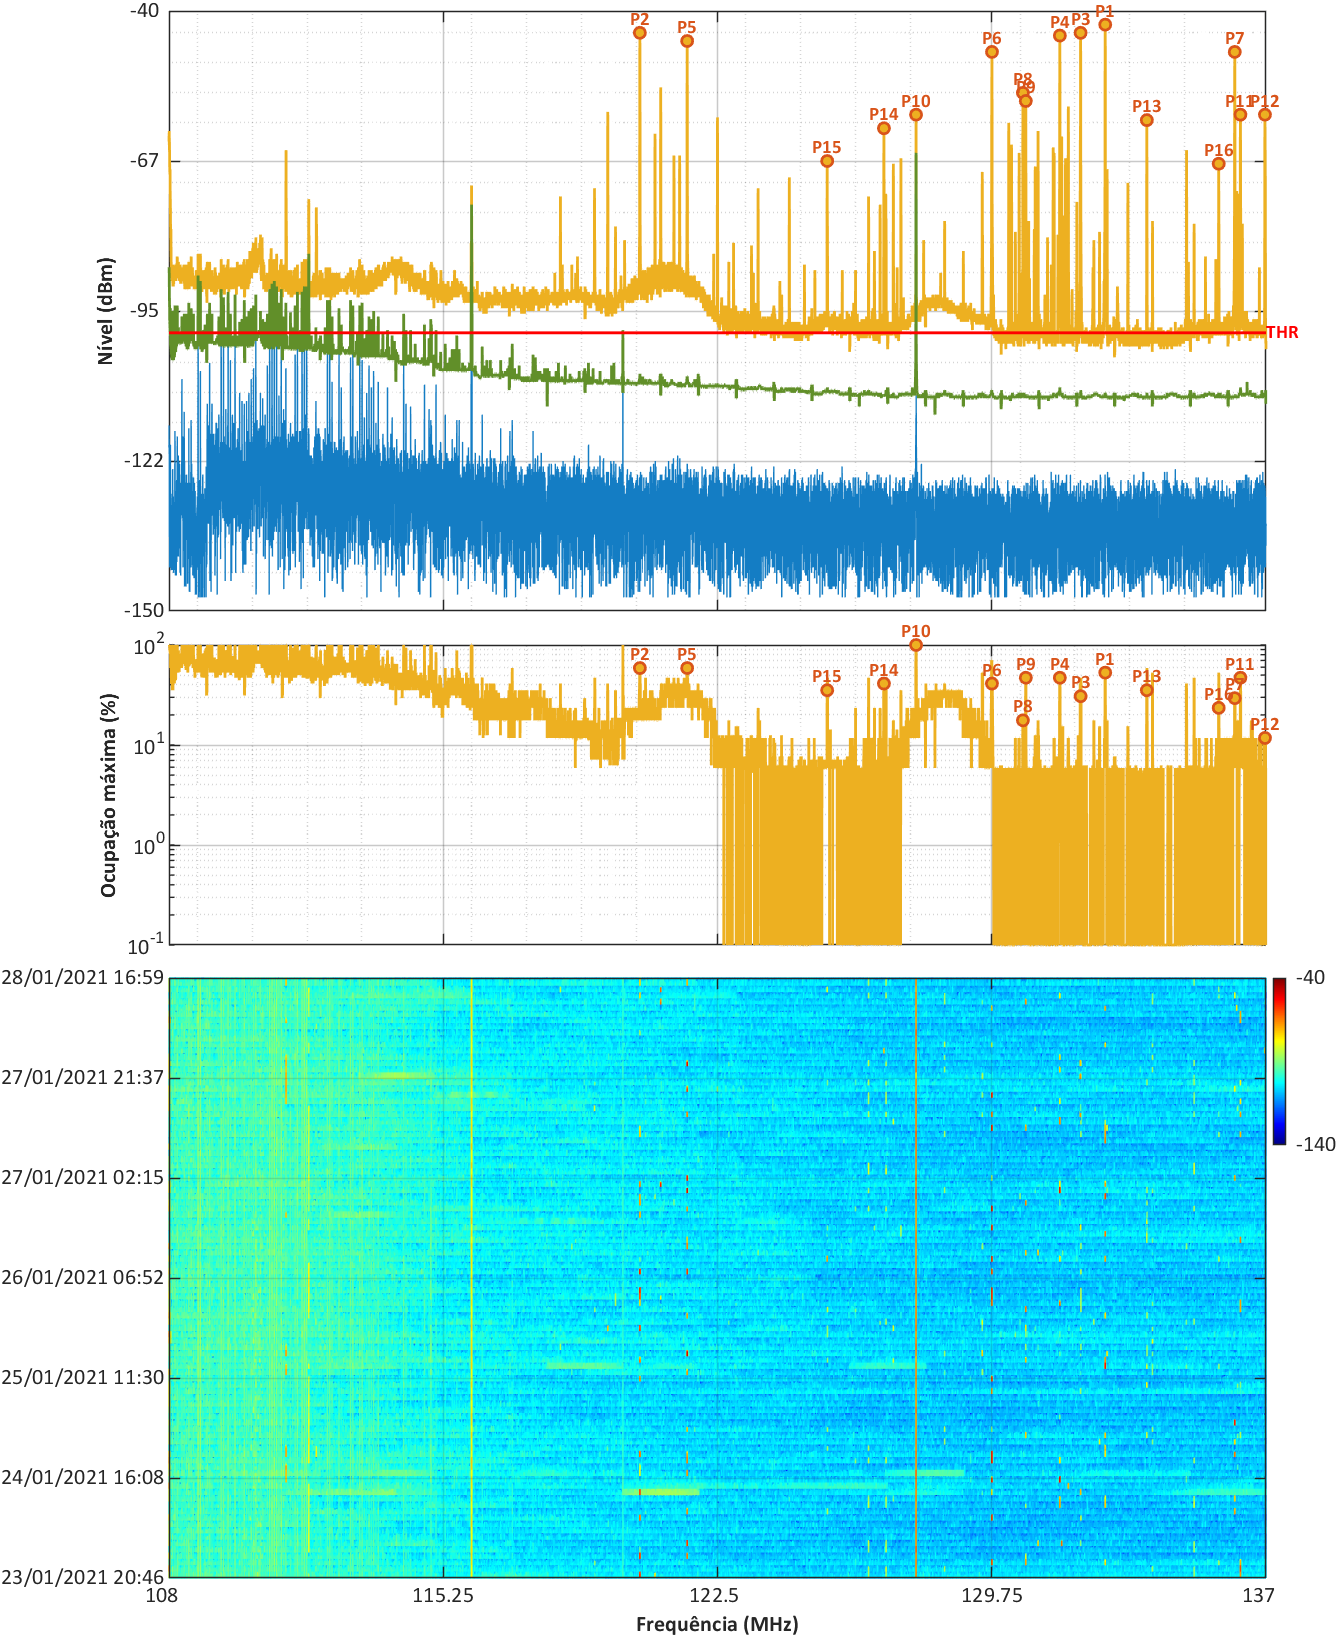

In [ ]:
validate_datadict(d, INSP, fiscaliza)

In [ ]:
d = defaultdict(str)
f = partialler(validate_datadict, d)
test_eq(f(), True)

In [ ]:
d = [('Servidor', 'Ronaldo')]
with ExceptionExpected(ex=AssertionError, regex='É esperado um dicionário'):
    validate_datadict(d)

In [ ]:
d = {}
d['Servidor'] = 'Ronaldo'
with ExceptionExpected(ex=ValueError, regex='As chaves seguintes são desconhecidas'):
    validate_datadict(d)

In [ ]:
with ExceptionExpected(ex=ValueError):
    validate_datadict({'Classe da Inspeção': 'Outorga'})

In [ ]:
with ExceptionExpected(ex=TypeError):
    validate_datadict({'Classe da Inspeção': ['Técnica']})
    validate_datadict({'Classe da Inspeção': 12})

In [ ]:
#export
def aguardando2andamento(insp, fields, fiscaliza=None):
    if fiscaliza is None:
        fiscaliza = auth_user()
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    status = str(getattr(issue, 'status', ''))
    #assert status == 'Aguardando Execução', f"O Status atual da Inspeção {status} é diferente de 'Aguardando Execução'"        
    status = list(STATUS.keys())[1]
    custom_fields = []
    relat, gerar = STATUS[status]
    if relatorio := fields.get(relat, None):
        #relatorio = relatorio.encode('unicode_escape').decode() #deals with Windows Paths
        relatorio = Path(relatorio).read_text()
        custom_fields.append({'id': FIELD2ID[relat], 'value': relatorio})
        custom_fields.append({'id': FIELD2ID[gerar], 'value': '1'})
    else:
        custom_fields.append({'id': FIELD2ID[relat], 'value': ''})
        custom_fields.append({'id': FIELD2ID[gerar], 'value': '0'})    

    status = SITUACAO[status]
    return fiscaliza.issue.update(issue.id, status_id=status, custom_fields=custom_fields)    

def andamento2relatando(insp, fields, fiscaliza=None):
    if fiscaliza is None:
        fiscaliza = auth_user()
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    status = str(getattr(issue, 'status', ''))
    if status != 'Em andamento':
        print(f"O Status atual da Inspeção {status} é diferente de 'Aguardando Execução'!!!!")        
    status = list(STATUS.keys())[2]
    custom_fields = []
    for field in STATUS[status]:
        updated_val = fields.get(field, '')
        custom_fields.append({'id': FIELD2ID[field], 'value': updated_val})
    assert (start_date := fields.get('Data de início', None)), f'O campo "Data de início" não pode ficar vazio!'
    assert (due_date := fields.get('Data limite', None)), f'O campo "Data limite" não poder ficar vazio!'
    issue_id = issue.id
    status = SITUACAO[status]
    return fiscaliza.issue.update(issue_id, start_date=start_date, due_date=due_date, status_id=status, custom_fields=custom_fields)

def relatando2relatado(insp, fields, fiscaliza=None, notes = None):
    if fiscaliza is None:
        fiscaliza = auth_user()
    issue = fiscaliza.issue.get(insp, include=['relations', 'attachments'])
    status = str(getattr(issue, 'status', ''))
    if status != 'Relatando':
        print(f"O Status atual da Inspeção {status} é diferente de 'Relatando'!!!!")        
    status = list(STATUS.keys())[3]
    custom_fields = []
    for field in STATUS[status]:
        updated_val = fields.get(field, '')
        if field in ('UF/Município', 'Serviços da Inspeção'):
            if type(updated_val) not in (tuple, list):
                updated_val = [updated_val]
            if field == 'Serviços da Inspeção':
                updated_val = [SERVICOS[val] for val in updated_val]
            updated_val = [value_text_string(val) for val in updated_val]
        custom_fields.append({'id': FIELD2ID[field], 'value': updated_val})
    issue_id = issue.id
    status = SITUACAO[status]
    return fiscaliza.issue.update(issue_id, status_id=status, notes=notes, custom_fields=custom_fields)

### Mostrar resumo da Ação à partir da Inspeção

In [ ]:
#hide
fiscaliza = auth_user(USR, PWD)
insp2acao(INSP, fiscaliza)

In [ ]:
detalhar_inspecao(INSP, fiscaliza)

## Rascunho -> Aguardando Execução

### Somente 1 Fiscal

In [ ]:
#hide
d = {}
d['Classe da Inspeção'] = 'Técnica'
d['Tipo de inspeção'] = 'Uso do Espectro - Monitoração'
d['Descrição da Inspeção'] = '''Atendimento da Denúncia AC202010213075425 (6104512), 
  verificação da Potência e Intensidade de Campo Elétrico da Frequência 105.1MHz e seus harmônicos, 
  além da checagem de Intermodulação e Espúrios nas frequências 450.3MHz e 750MHz.'''
d['Fiscal responsável '] = 'Ronaldo da Silva Alves Batista'
d['Fiscais '] = 'Paulo Diogo Costa'
rascunho2aguardando(INSP, d, fiscaliza)

In [ ]:
detalhar_inspecao('51804', fiscaliza)

### Múltiplos Fiscais

In [ ]:
#hide
d = {}
d['Fiscais '] = ['Ronaldo da Silva Alves Batista', 'Paulo Diogo Costa', 'Mario Augusto Volpini']
rascunho2aguardando(INSP, d)

## Aguardando Execução -> Andamento

In [ ]:
#hide
d['Html'] = r'D:\OneDrive - ANATEL\Monitoramento\Processos\535040005152021-38\Report_2021.02.18_T23.49.55.html'
d[' Gerar Relatório '] = 1

In [ ]:
#hide
aguardando2andamento(INSP, d)

## Andamento -> Relatando

In [ ]:
#hide
d = {}
d['Frequência inicial']  = 54
d['Unidade da frequência inicial'] = 'MHz'
d['Frequência final'] = 700
d['Unidade da frequência final'] = 'MHz'
d['Data de início'] = '2021-03-19'
d['Data limite'] = '2021-12-31'

In [ ]:
#hide
andamento2relatando(INSP, d)

## Relatando -> Relatada
O Relatório de Atividades Criado no SEI no passo anterior deve estar assinado.

### 1 Município e 1 Serviço

In [ ]:
#hide
d = {}
d['UF/Município'] = "SP/São Paulo"
d['Serviços da Inspeção'] = '230'
d['Qnt. de emissões na faixa'] = 12
d['Emissões não autorizadas/desc'] = 70
d['Horas de Preparação'] = 2
d['Horas de Deslocamento'] = 0
d['Horas de Execução'] = 32
d['Horas de conclusão'] = 6
d['Latitude (coordenadas)'] = -22.94694
d['Longitude (coordenadas)'] = -43.21944
d['Uso de PF'] = 'Não se aplica PF - uso apenas de formulários'
d['Ação de risco à vida criada?'] = 'Não'
d['Impossibilidade acesso online?'] = '0'

In [ ]:
#hide
relatando2relatado(INSP, d)

### Adicionar uma tabela ao journal
Primeira linha é o título da tabelas, separado por vírgula, demais linhas são os valores. 

In [ ]:
#hide
journal = """Faixa, Classe Especial, Classe A, Classe B, Classe C
VHF-L,0,5,7,5
VHF-H,0,12,1,0
UHF,1,1,2,4
FM,5,1,0,0
RADCOM,0,0,0,0
Outorgadas com indícios de irregularidades,1,2,3,4
"""

In [ ]:
#hide
import pandas as pd
table = [[r.strip() for r in j.split(',')] for j in journal.split('\n') if j]
assert len(set([len(t) for t in table])) == 1
df = pd.DataFrame(table[1:], columns=table[0])
notes = df.to_markdown(index=False, tablefmt='textile')

In [ ]:
#hide
relatando2relatado(INSP, d, notes=notes)

In [ ]:
#hide
d = detalhar_inspecao(INSP) ; d

In [ ]:
from nbdev.export import notebook2script
notebook2script()